# Part II - Land-Use Change Analysis (1999-2018)

Augusto Pablo Salonio Carbó  
2025-11-11

## 1. Overview

Full transition analysis using the 8-class rasters produced in Part I.

### Key outputs:

-   Initial area (1999) km² per class

-   Full transition matrix (ha → km²)

-   Sankey diagrams (All + top 15 dynamic)

-   Area-by-class bar plots (1999/2009/2018)

-   Spatial maps of top-3 major transitions (interactive + static)

-   Summary tables (km² & % of total / dynamic area)

## 2. Packages & Paths

In [ ]:
library(terra)
library(tidyterra)
library(dplyr)
library(tidyr)
library(sf)
library(openxlsx)
library(plotly)
library(webshot)
library(htmlwidgets)
library(ggplot2)
library(tmap)
library(RColorBrewer)

repo_root <- rprojroot::find_root(rprojroot::is_git_root)

raw_dir   <- file.path(repo_root, "data")
bound_dir <- file.path(repo_root, "data")
out_dir   <- file.path(repo_root, "output") 

dir.create(out_dir, showWarnings = FALSE, recursive = TRUE)

## 3. Load Reclassified Rasters and Region boundaries

In [ ]:
reclass_cover_1999 <- rast(file.path(out_dir, "reclass_cover_1999.tif"))
reclass_cover_2009 <- rast(file.path(out_dir, "reclass_cover_2009.tif"))
reclass_cover_2018 <- rast(file.path(out_dir, "reclass_cover_2018.tif"))

lim_32719 <- vect(file.path(bound_dir, "lim_32719.shp"))

## 4. Align & Stack Rasters

In [ ]:
class_names <- c("Water_Bare", "Native", "Plant", "Shrub", "Crop", "Grass", "Urban", "Peat")

reclass_cover_2009_a <- resample(reclass_cover_2009, reclass_cover_1999, method = "near")
reclass_cover_2018_a <- resample(reclass_cover_2018, reclass_cover_1999, method = "near")

mask <- !is.na(reclass_cover_1999)
reclass_cover_1999_m <- mask(reclass_cover_1999, mask)
reclass_cover_2009_m <- mask(reclass_cover_2009_a, mask)
reclass_cover_2018_m <- mask(reclass_cover_2018_a, mask)

reclass_cover_1999_m <- as.factor(reclass_cover_1999_m)
reclass_cover_2009_m <- as.factor(reclass_cover_2009_m)
reclass_cover_2018_m <- as.factor(reclass_cover_2018_m)

rats <- c(reclass_cover_1999_m, reclass_cover_2009_m, reclass_cover_2018_m)
levels(rats) <- data.frame(ID = 1:8, Class = class_names)
lc_stack <- rats

## 5. Full Transition Table (km²)

In [ ]:
pixel_area_m2 <- prod(res(reclass_cover_1999))
pixel_to_km2   <- function(count) {
  count * pixel_area_m2 / 1e6
}

lc_stack_i <- c(as.int(reclass_cover_1999_m), 
                as.int(reclass_cover_2009_m), 
                as.int(reclass_cover_2018_m))

ct <- crosstab(lc_stack_i, useNA = FALSE)
ct_df <- as.data.frame(ct) |> 
  rename(y1999 = Category, y2009 = Category.1, y2018 = Category.2) |> 
  filter(Freq > 0) |> 
  mutate(
    area_km2 = pixel_to_km2(Freq),
    Type = if_else(y1999 == y2009 & y2009 == y2018, "Stable", "Dynamic"),
    from_1999 = class_names[y1999],
    from_2009 = class_names[y2009],
    to_2018   = class_names[y2018]
  ) |>
  arrange(desc(area_km2))

## 6. Sankey Diagrams

### 6.1 All transitions

In [ ]:
sankey_data_plotly <- function(df, val = "Freq") {
  
  cls <- unique(c(df$from_1999, df$from_2009, df$from_2018))
  nodes <- data.frame(
    name = c(
      paste0("1999_", cls),
      paste0("2009_", cls),
      paste0("2018_", cls)
    )
  )
  
  node_map <- setNames(0:(nrow(nodes)-1), nodes$name)
  
  links <- rbind(
    data.frame(
      source = node_map[paste0("1999_", df$from_1999)],
      target = node_map[paste0("2009_", df$from_2009)],
      value  = df[[val]]
    ),
    data.frame(
      source = node_map[paste0("2009_", df$from_2009)],
      target = node_map[paste0("2018_", df$to_2018)],
      value  = df[[val]]
    )
  ) |> 
    group_by(source, target) |> 
    summarise(value = sum(value), .groups = "drop")
  
  list(nodes = nodes, links = links)
}

sankey_all <- sankey_data_plotly(ct_df)

sa <- plot_ly(
  type = "sankey",
  node = list(
    label = sankey_all$nodes$name,
    pad = 15,
    thickness = 20
  ),
  link = list(
    source = sankey_all$links$source,
    target = sankey_all$links$target,
    value  = sankey_all$links$value
  )
)

dir.create("sankeys", showWarnings = FALSE)
saveWidget(sa, "sankeys/sankey_all.html", selfcontained = TRUE)

[Check out Sankey with all transitions](sankeys/sankey_all.html)

### 6.2 Top-15 dynamic transitions

In [ ]:
ct_major <- ct_df |> 
  filter(Type == "Dynamic") |> 
  arrange(desc(area_km2)) |> 
  slice_head(n = 15)

sankey_major <- sankey_data_plotly(ct_major, "area_km2")

sm <- plot_ly(
  type = "sankey",
  node = list(label = sankey_major$nodes$name),
  link = list(
    source = sankey_major$links$source,
    target = sankey_major$links$target,
    value = sankey_major$links$value
    )
  )

saveWidget(sm, "sankeys/sankey_top15.html", selfcontained = TRUE)

[Check out Sankey with Top-15 dynamic
transitions](sankeys/sankey_all.html)

## 7. Area per Class Over Time (km²)

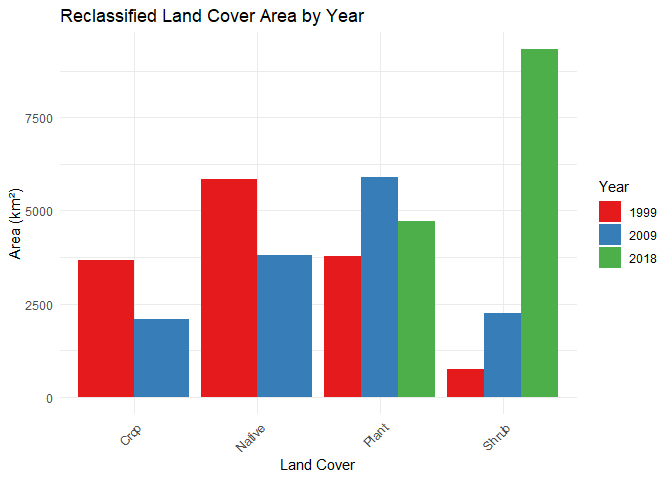

In [ ]:
area_time <- ct_major |> 
  pivot_longer(
    c(from_1999, from_2009, to_2018), 
    names_to = "Year", 
    values_to = "Class") |> 
  mutate(
    Year = recode(Year, from_1999="1999", from_2009="2009", to_2018="2018"),
    Year = factor(Year, c("1999","2009","2018"))
    ) |> 
  group_by(Year, Class) |>  
  summarise(
    area_km2 = sum(area_km2), 
    .groups ='drop')

ggplot(area_time, aes(x = Class, y = area_km2, fill = Year)) +
  geom_col(position = "dodge") +
  scale_fill_brewer(palette = "Set1") +
  labs(
    title = "Reclassified Land Cover Area by Year", 
    x = "Land Cover", 
    y = "Area (km²)") +
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

## 8. Spatial Map of Top-3 Transitions

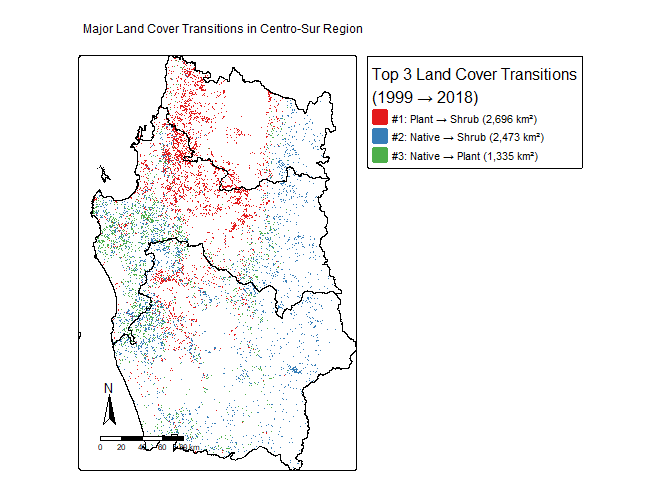

In [ ]:
ct_top3 <- ct_df |>  
  filter(Type == "Dynamic") |>  
  arrange(desc(area_km2)) |>  
  slice_head(n = 3) |> 
  mutate(
    rank = row_number(),
    transition_name = paste0("#", rank, ": ", from_1999, " → ", to_2018, 
                            " (", format(round(area_km2, 0), big.mark = ","), " km²)")
  )

ct_top3 <- ct_top3 |> 
  mutate(
    v1999 = match(from_1999, class_names),
    v2009 = match(from_2009, class_names),
    v2018 = match(to_2018, class_names),
    trans_val = v1999 * 100 + v2009 * 10 + v2018
  )

transition_raster <- (as.int(reclass_cover_1999_m) * 100) +
                      as.int(reclass_cover_2009_m * 10) +
                      as.int(reclass_cover_2018_m)


top3_rast <- transition_raster
top3_rast[!top3_rast %in% ct_top3$trans_val] <- NA


levels(top3_rast) <- data.frame(
  value = ct_top3$trans_val,
  label = ct_top3$transition_name
)


top3_colors <- c("#e41a1c", "#377eb8", "#4daf4a")  # Red, Blue, Green


tm_top3 <- tm_shape(top3_rast) +
  tm_raster(
    style = "cat", 
    palette = top3_colors,
    title = "Top 3 Land Cover Transitions\n(1999 → 2018)",
    labels = levels(top3_rast)[[1]]$label
  ) +
  tm_shape(lim_32719) + 
  tm_borders(col = "black", lwd = 1.5) +
  tm_layout(
    main.title = "Major Land Cover Transitions in Centro-Sur Region",
    main.title.size = 1.2,
    legend.outside = TRUE, 
    legend.outside.position = "right",
    legend.title.size = 1,
    legend.text.size = 0.7,
    frame = TRUE
  ) +
  tm_compass(position = c("left", "bottom")) +
  tm_scale_bar(position = c("left", "bottom"))

print(tm_top3)

## 9. Transitions Summary (km² & %)

In [ ]:
transition_summary <- ct_top3 |> 
  select(rank, from_1999, from_2009, to_2018, area_km2) |> 
  mutate(
    area_km2 = round(area_km2, 1),
    pct_total = round((area_km2 / sum(ct_df$area_km2)) * 100, 2), #Percentage of Total study area (including stable areas)
    pct_dynamic = round((area_km2 / sum(ct_df$area_km2[ct_df$Type == "Dynamic"])) * 100, 2) # Percentage of Dynamic areas only (areas that changed)
  )

print(transition_summary)

  rank from_1999 from_2009 to_2018 area_km2 pct_total pct_dynamic
1    1     Plant     Plant   Shrub   2695.6      3.92       11.43
2    2    Native    Native   Shrub   2473.1      3.59       10.49
3    3    Native    Native   Plant   1335.2      1.94        5.66

## 10. Insights

**1. Plantation to Shrubland Dominates (2,696 km²)** The Plant→Shrub
transition affected 3.92% of the total study area and represented 11.43%
of all land cover changes during 1999-2018, mostly concentrated in
northern Ñuble and Bio-Bio regions. This likely reflects harvested Pinus
radiata plantations transitioning to shrub during regeneration,
potentially exacerbated by fire disturbance in the 2009-2018 period.

**2. Native Forest Loss Through Two Pathways (3,069 km²)** Native→Shrub
(1,857 km²) and Native→Plant (1,212 km²) together affected 5.53% of the
total study area and represented 16.15% of all land cover changes. The
Native→Plant transition occurs predominantly in accessible SW Bio-Bio
lowlands (active conversion), whilst Native→Shrub occurs along Andean
slopes in all three regions (likely fire-induced degradation). This
spatial segregation suggests different drivers requiring targeted
management approaches.

**3. Temporal Acceleration** Following Part I insights, these major
transitions occurred predominantly between 2009 and 2018, coinciding
with intensified wildfire activity and mega-drought conditions in
central Chile. The rapid rise in shrubland cover (+5300 km² regionally)
creates higher fine-fuel loads and elevates future fire risk.

## 11. Export

In [ ]:
write.csv2(ct_df, 
          file.path(out_dir, "full_transition_matrix_km2.csv"), 
          row.names = FALSE)

write.xlsx(transition_summary, 
           file.path(out_dir, "top3_transition_summary.xlsx"))

tmap_save(tm_top3, file.path(out_dir, "top3_transitions_map.png"),
          width = 12, height = 8, units = "in")